In [1]:
# Copyright (c) Xuanyi Dong [GitHub D-X-Y], 2020.06 
# Copyright [2024] Stefan Dendorfer
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""
This notebook used to start runs on NATS Bench

Requirements: 

-This notebook requires that torch and numpy be installed within the 
Python environment you are running this script in. 


- This script requires the nats_bench package
    pip install nats_bench

- make sure to have nats run data saved at DIR folder
 
"""

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from nats_bench import create
import numpy as np 
import os
import torch
from collections import OrderedDict

api = create(None, "tss", fast_mode=True, verbose=False)

[2024-06-03 15:12:54] Try to use the default NATS-Bench (topology) path from fast_mode=True and path=None.


In [2]:
'''For a quick workaround, use the data from run results on NATS-Bench as 
provided. If you prefer to generate the run data yourself, run the command
    
    python ./scripts/create_nats_data.py 

'''

DIR = os.path.join("..","provided_data","provided")
# DIR = os.path.join("..","data","generated")

In [3]:
def fetch_data(root_dir=DIR, search_space="tss", dataset=None, algorithms=["REA","REINFORCE"]):
    ss_dir = "{:}-{:}".format(root_dir, search_space)
    alg2name, alg2path = OrderedDict(), OrderedDict()
    for alg in algorithms:
        alg2name[alg] = alg
    for alg, name in alg2name.items():
        alg2path[alg] = os.path.join(ss_dir, dataset, name, "results.pth")
        assert os.path.isfile(alg2path[alg]), "invalid path : {:}".format(alg2path[alg])
    alg2data = OrderedDict()
    for alg, path in alg2path.items():
        data = torch.load(path)
        for index, info in data.items():
            info["time_w_arch"] = [
                (x, y) for x, y in zip(info["all_total_times"], info["all_archs"])
            ]
            for j, arch in enumerate(info["all_archs"]):
                assert arch != -1, "invalid arch from {:} {:} {:} ({:}, {:})".format(
                    alg, search_space, dataset, index, j
                )
        alg2data[alg] = data
    return alg2data


def query_performance(api, data, dataset, ticket):
    results, is_size_space = [], api.search_space_name == "size"
    for i, info in data.items():
        time_w_arch = sorted(info["time_w_arch"], key=lambda x: abs(x[0] - ticket))
        time_a, arch_a = time_w_arch[0]
        time_b, arch_b = time_w_arch[1]
        info_a = api.get_more_info(
            arch_a, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
        )
        info_b = api.get_more_info(
            arch_b, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
        )
        accuracy_a, accuracy_b = info_a["test-accuracy"], info_b["test-accuracy"]
        interplate = (time_b - ticket) / (time_b - time_a) * accuracy_a + (
            ticket - time_a
        ) / (time_b - time_a) * accuracy_b
        results.append(interplate)
    return np.mean(results), np.std(results)


def show_valid_test(api, data, dataset):
    valid_accs, test_accs, is_size_space = [], [], api.search_space_name == "size"
    for i, info in data.items():
        time, arch = info["time_w_arch"][-1]
        if dataset == "cifar10":
            xinfo = api.get_more_info(
                arch, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
            )
            test_accs.append(xinfo["test-accuracy"])
            xinfo = api.get_more_info(
                arch,
                dataset="cifar10-valid",
                hp=90 if is_size_space else 200,
                is_random=False,
            )
            valid_accs.append(xinfo["valid-accuracy"])
        else:
            xinfo = api.get_more_info(
                arch, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
            )
            valid_accs.append(xinfo["valid-accuracy"])
            test_accs.append(xinfo["test-accuracy"])
    valid_str = "{:.2f}$\pm${:.2f}".format(np.mean(valid_accs), np.std(valid_accs))
    test_str = "{:.2f}$\pm${:.2f}".format(np.mean(test_accs), np.std(test_accs))
    return valid_str, test_str



def visualize_curve(api, exp, dataset, axes, search_space="tss"):
    def sub_plot_fn(ax, dataset, exp):
        xdataset, max_time = dataset.split("-T")
        algorithms_labels = [d[0] for d in exp["data"].items()]
        algorithms = [d[1][0] for d in exp["data"].items()]
        alg2data = fetch_data(search_space=search_space, dataset=dataset, algorithms=algorithms)
        total_tickets = 150
        time_tickets = [
            float(i) / total_tickets * int(max_time) for i in range(total_tickets)
        ]
        tc = {'Blue': '#5F9ED1','Red Orange': '#C85200'}
        colors = [tc[d[1][1]] for d in exp["data"].items()]


        xs = [x for x in time_tickets]

        for idx, (alg, data) in enumerate(alg2data.items()):
            accuracies = []
            for ticket in time_tickets:
                cur_mean, _ = query_performance(api, data, xdataset, ticket)
                accuracies.append(cur_mean) 
            budgets=[2e4,2e5]
            budget_strings = ["2e4","2e5"]
            
            for i in range(2):
                ax = axes[i]
                budget = budgets[i]
                ax.set_xlim(0,int(budget))
                budget= 200000
                ax.set_ylim(
                    exp["limits"][xdataset][0], exp["limits"][xdataset][1]
                )
                ax.plot(
                    xs,
                    accuracies,
                    c=colors[idx],
                    label="{:}".format(algorithms_labels[idx]),
                )
                ax.set_ylabel("accuracy")
                ax.set_xlabel('total training time spent (seconds)')
                ax.set_title(f"Time Budget of {budget_strings[i]} seconds")
                formatter = ticker.ScalarFormatter(useMathText=True)
                formatter.set_powerlimits((1,4))
                ax.xaxis.set_major_formatter(formatter)
                ax.legend(loc=4)
    sub_plot_fn(axes, dataset, exp)


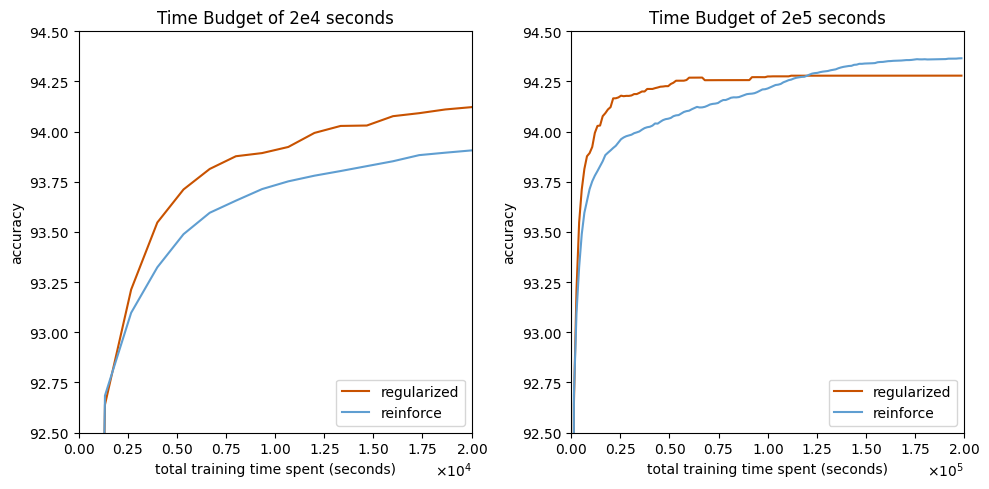

In [4]:
'''Here we compare regularized evolution and reinforce on different time budgets'''
exp = {
    "data": 
    {
        "regularized" : ["R-EA-SS10","Red Orange"],
        "reinforce" : ["REINFORCE-0.01","Blue"],
    },
    "limits" : {"cifar10": (92.5,94.5)},
   
}

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
print("Plotting and interpolating 1000 runs. This may take a while...")
visualize_curve(api, exp, "cifar10-T200000", axes)
plt.tight_layout()
plt.show()